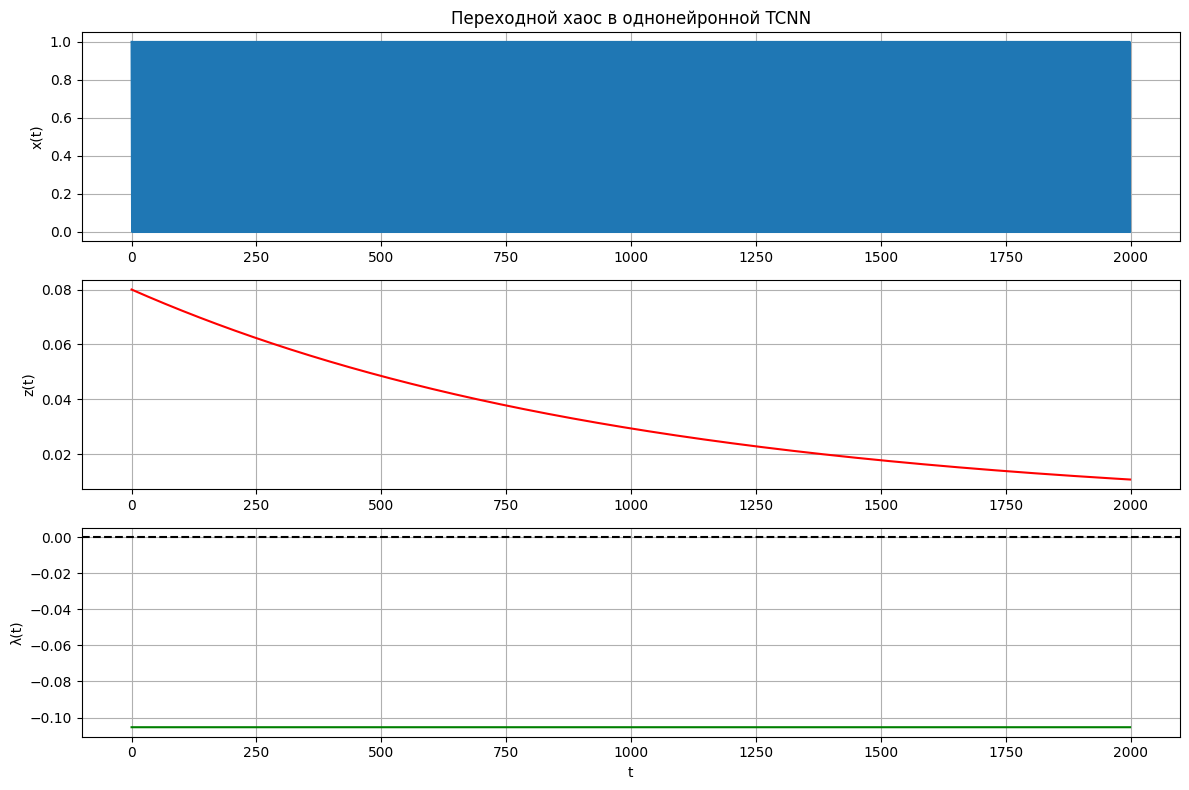

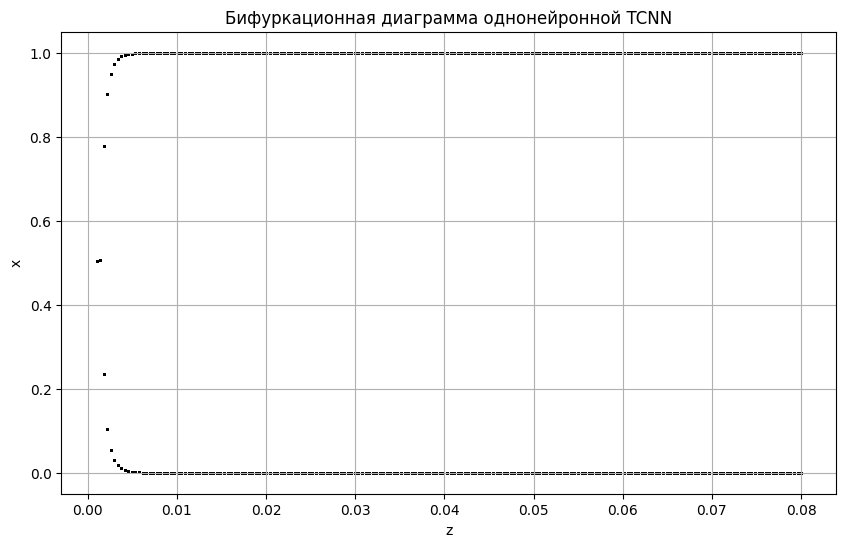

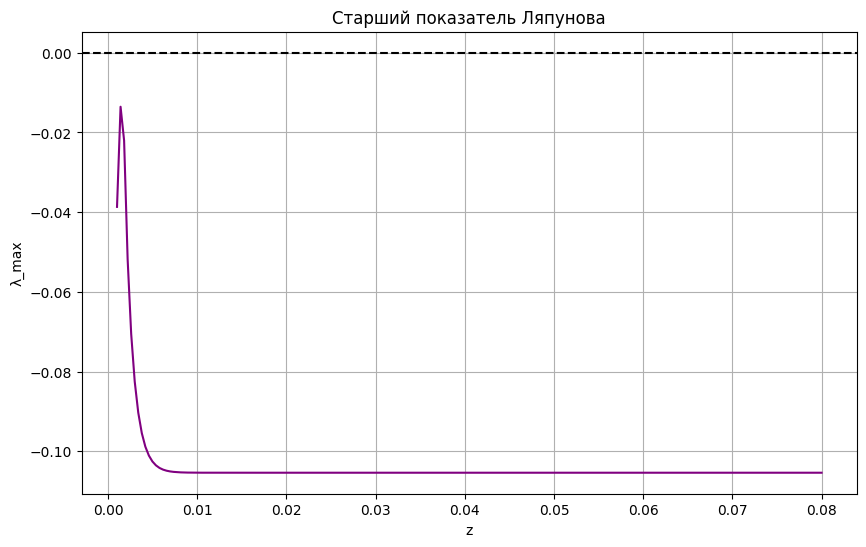

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1. ОДНОНЕЙРОННАЯ TCNN (Cheng–Aihara)
# ============================================================

def single_neuron_tcnn(y0, k, c, I0, gamma, z0, beta, T):
    """
    Однонейронная TCNN с затухающей отрицательной самосвязью z(t)
    """
    y = y0
    z = z0

    y_hist = np.zeros(T)
    x_hist = np.zeros(T)
    z_hist = np.zeros(T)

    for t in range(T):
        # Сигмоидальная активация
        x = 1.0 / (1.0 + np.exp(-y / c))

        # Основное отображение TCNN
        y_new = k * y + gamma - z * (x - I0)

        # Экспоненциальное затухание z(t)
        z_new = (1.0 - beta) * z

        # Сохранение истории
        y_hist[t] = y
        x_hist[t] = x
        z_hist[t] = z

        y = y_new
        z = z_new

    return y_hist, x_hist, z_hist


# ============================================================
# 2. ПЕРЕХОДНОЙ ПОКАЗАТЕЛЬ ЛЯПУНОВА λ(t)
# ============================================================

def transient_lyapunov(y_hist, z_hist, k, c):
    """
    Переходной старший показатель Ляпунова λ(t)
    """
    lyap = np.zeros(len(y_hist))
    s = 0.0

    for t in range(len(y_hist)):
        y = y_hist[t]
        z = z_hist[t]

        exp_term = np.exp(-y / c)
        fp = (1.0 / c) * exp_term / (1.0 + exp_term)**2

        derivative = k - z * fp
        s += np.log(abs(derivative) + 1e-12)

        lyap[t] = s / (t + 1)

    return lyap


# ============================================================
# 3. БИФУРКАЦИОННАЯ ДИАГРАММА (x vs z)
# ============================================================

def bifurcation_diagram(k, c, I0, gamma, z_values, y0, T, discard):
    """
    Бифуркационная диаграмма x(z) при фиксированном z
    """
    Z = []
    X = []

    for z in z_values:
        y = y0

        for t in range(T):
            x = 1.0 / (1.0 + np.exp(-y / c))
            y = k * y + gamma - z * (x - I0)

            if t > discard:
                Z.append(z)
                X.append(x)

    return np.array(Z), np.array(X)


# ============================================================
# 4. λ_max ПРИ ФИКСИРОВАННОМ z
# ============================================================

def lyapunov_fixed_z(k, c, I0, gamma, z, y0, T):
    """
    Старший показатель Ляпунова при фиксированном z
    """
    y = y0
    s = 0.0

    for _ in range(T):
        exp_term = np.exp(-y / c)
        x = 1.0 / (1.0 + exp_term)
        fp = (1.0 / c) * exp_term / (1.0 + exp_term)**2

        derivative = k - z * fp
        s += np.log(abs(derivative) + 1e-12)

        y = k * y + gamma - z * (x - I0)

    return s / T


# ============================================================
# 5. ПАРАМЕТРЫ (из статьи Cheng–Aihara)
# ============================================================

k = -0.9
c = 1.0 / 250.0
I0 = 0.65
gamma = 0.0
y0 = 0.5

z0 = 0.08
beta = 0.001

T = 10000


# ============================================================
# 6. ПЕРЕХОДНОЙ ХАОС: x(t), z(t), λ(t)
# ============================================================

y_hist, x_hist, z_hist = single_neuron_tcnn(
    y0, k, c, I0, gamma, z0, beta, T
)

lyap_t = transient_lyapunov(y_hist, z_hist, k, c)

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(x_hist[:2000])
plt.ylabel("x(t)")
plt.title("Переходной хаос в однонейронной TCNN")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(z_hist[:2000], color="red")
plt.ylabel("z(t)")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(lyap_t[:2000], color="green")
plt.axhline(0, linestyle="--", color="black")
plt.ylabel("λ(t)")
plt.xlabel("t")
plt.grid(True)

plt.tight_layout()
plt.show()


# ============================================================
# 7. БИФУРКАЦИОННАЯ ДИАГРАММА
# ============================================================

z_vals = np.linspace(0.001, 0.08, 200)

Z, X = bifurcation_diagram(
    k, c, I0, gamma,
    z_vals, y0,
    T=8000,
    discard=3000
)

plt.figure(figsize=(10, 6))
plt.scatter(Z, X, s=0.1, color="black")
plt.xlabel("z")
plt.ylabel("x")
plt.title("Бифуркационная диаграмма однонейронной TCNN")
plt.grid(True)
plt.show()


# ============================================================
# 8. λ_max(z)
# ============================================================

lyap_vals = []
for z in z_vals:
    lyap_vals.append(
        lyapunov_fixed_z(k, c, I0, gamma, z, y0, 8000)
    )

plt.figure(figsize=(10, 6))
plt.plot(z_vals, lyap_vals, color="purple")
plt.axhline(0, linestyle="--", color="black")
plt.xlabel("z")
plt.ylabel("λ_max")
plt.title("Старший показатель Ляпунова")
plt.grid(True)
plt.show()
